In [1]:
import pandas as pd
import numpy as np

import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from collections import Counter

import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  preprocessedDataPath = '/content/drive/Othercomputers/Компьютер/predicting-academic-performance 2.0/v2.0/preprocessed_data'
  dataPath = '/content/drive/Othercomputers/Компьютер/predicting-academic-performance 2.0/data'
else:
  preprocessedDataPath = 'preprocessed_data'
  dataPath = '../data'

In [4]:
df = pd.read_csv(os.path.join(preprocessedDataPath, 'final.csv'))

zakonchili_obuchenie_id = pd.read_csv(os.path.join(preprocessedDataPath,'zakonchili_obuchenie_id.csv'))
akademshiki_id = pd.read_csv(os.path.join(preprocessedDataPath,'akademshiki_id.csv'))
otchislennie_id = pd.read_csv(os.path.join(preprocessedDataPath,'otchislennie_id.csv'))

In [5]:
lst = pd.read_csv(os.path.join(dataPath,'lichnost.csv'))
lst.loc[lst['POL_ID'] == 2, 'POL_ID'] = 0

lst_dict_id_pol = dict(lst.groupby('GUID')['POL_ID'].min())

In [6]:
df.columns

Index(['LICHNOST_GUID', 'BALL', 'SEMESTR_ZAKRIT_DISC', 'ISPRAV', 'min',
       'sub_min', 'max', 'sub_max', 'mean', 'sub_mean', 'median', 'sub_median',
       'percent_better_than_rest', 'VID_ATT_Зачет', 'VID_ATT_Курсовая работа',
       'VID_ATT_Курсовой проект', 'VID_ATT_Экзамен'],
      dtype='object')

In [7]:
df = df.sort_values(by=['LICHNOST_GUID', 'SEMESTR_ZAKRIT_DISC'])

In [8]:
features = ['BALL', 'ISPRAV', 'VID_ATT_Зачет', 'VID_ATT_Курсовая работа', 'VID_ATT_Курсовой проект', 'VID_ATT_Экзамен', 'sub_min', 'sub_max', 'sub_mean', 'sub_median', 'percent_better_than_rest']

In [9]:
pca = PCA(n_components=1)
pca.fit(df[features].to_numpy())

PCA(n_components=1)

In [10]:
cntr = Counter()

final_matrix = []
max_len_data = 0

for lichnost_guid, lichnost_group_data in df.groupby('LICHNOST_GUID'):
    lichnost_matrix = []

    for semestr, semestr_group_data in lichnost_group_data.groupby('SEMESTR_ZAKRIT_DISC'):
        semestr_group_data_pca = [int(lichnost_guid not in (zakonchili_obuchenie_id.to_numpy()))]
        semestr_group_data_pca.append(lst_dict_id_pol[lichnost_guid])

        semestr_group_data_pca.extend((pca.transform(semestr_group_data[features].to_numpy())).T[0])

        cntr[f"{lichnost_guid} - {semestr}"] += len(semestr_group_data_pca) - 1

        lichnost_matrix.append(semestr_group_data_pca)

    final_matrix.append(lichnost_matrix)


In [11]:
max_subjects_per_semestr = cntr.most_common(1)[0][1]

In [12]:
max_subjects_per_semestr

41

In [13]:
def collate_fn_with_padding(semestri_vseh, pad_id=0):
    max_count_semestrs = max(len(semestri_odnogo) for semestri_odnogo in semestri_vseh)
    new_batch = []
    for semestri_odnogo in semestri_vseh:
        new_semestri_odnogo = []
        for semestr in semestri_odnogo:
            semestr += [pad_id] * (max_subjects_per_semestr + 1 - len(semestr))
            new_semestri_odnogo.append(semestr)

        for _ in range(max_count_semestrs - len(semestri_odnogo)):
            new_semestri_odnogo.append([semestri_odnogo[0][0]] + ([pad_id] * (max_subjects_per_semestr)))

        new_batch.append(new_semestri_odnogo)

    float_tensor = torch.FloatTensor(new_batch).to(device)

    new_batch = {
        'input_ids': float_tensor[:,:, 1:],
        'target_ids': float_tensor[:,:, 0]
    }

    return new_batch


In [14]:
class OcenkaDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx: int) -> list[int]:
        return self.data[idx]

    def __len__(self) -> int:
        return len(self.data)

In [15]:
train_ocenka, eval_ocenka = train_test_split(final_matrix, test_size=0.2)
# eval_ocenka, test_ocenka = train_test_split(eval_ocenka, test_size=0.5)

train_dataset = OcenkaDataset(train_ocenka)
eval_dataset = OcenkaDataset(eval_ocenka)
# test_dataset = OcenkaDataset(test_ocenka)

batch_size = 1

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# test_dataloader = DataLoader(
#     test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [16]:
class OtchislenieModel_GRU(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_LSTM(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.RNN(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_GRU_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.GRU(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_LSTM_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.LSTM(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

In [17]:
def show_loss_f1_auc_graphs(losses, f1s, fpr, tpr, thresholds): # Создание трех графиков
    epochs = np.arange(1, len(losses)+1)

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))

    axs[0].plot(epochs, losses, color='blue')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('Epoch')

    axs[1].plot(epochs, f1s, color='red')
    axs[1].set_title('F1')
    axs[1].set_xlabel('Epoch')

    roc_auc = auc(fpr, tpr)

    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].set_title('Receiver Operating Characteristic (ROC)')

    plt.tight_layout()
    plt.show()

In [18]:
def evaluate(model, dataloader):
    model.eval()
    logits = []
    y_trues = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Testing'):
            logit = torch.round(model(batch['input_ids']).cpu().flatten()[-1])
            y_true = batch['target_ids'].cpu().flatten()[-1]
            logits.append(logit)
            y_trues.append(y_true)

    return y_trues, logits

In [19]:
def train_model(model, optimizer, criterion, num_epoch=25):
    losses = []
    f1s = []
    rocs = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten()
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        y_true, y_pred = evaluate(model, eval_dataloader)
        print(classification_report(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
        rocs.append(roc_auc_score(y_true, y_pred))

        # clear_output(wait=True)
        print(f'Min Loss = {min(losses)}, Curr F1 = {f1s[-1]}, Max F1 = {max(f1s)}, Curr AUC_ROC = {rocs[-1]}, Max AUC_ROC = {max(rocs)}')
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        show_loss_f1_auc_graphs(losses, f1s, fpr, tpr, thresholds)

    return model

Vanilla RNN Base Structure

Training epoch 1:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78      1231
         1.0       0.85      0.73      0.79      1498

    accuracy                           0.78      2729
   macro avg       0.79      0.79      0.78      2729
weighted avg       0.79      0.78      0.78      2729

Min Loss = 0.6086374888561675, Curr F1 = 0.7880747126436781, Max F1 = 0.7880747126436781, Curr AUC_ROC = 0.7893880169497592, Max AUC_ROC = 0.7893880169497592


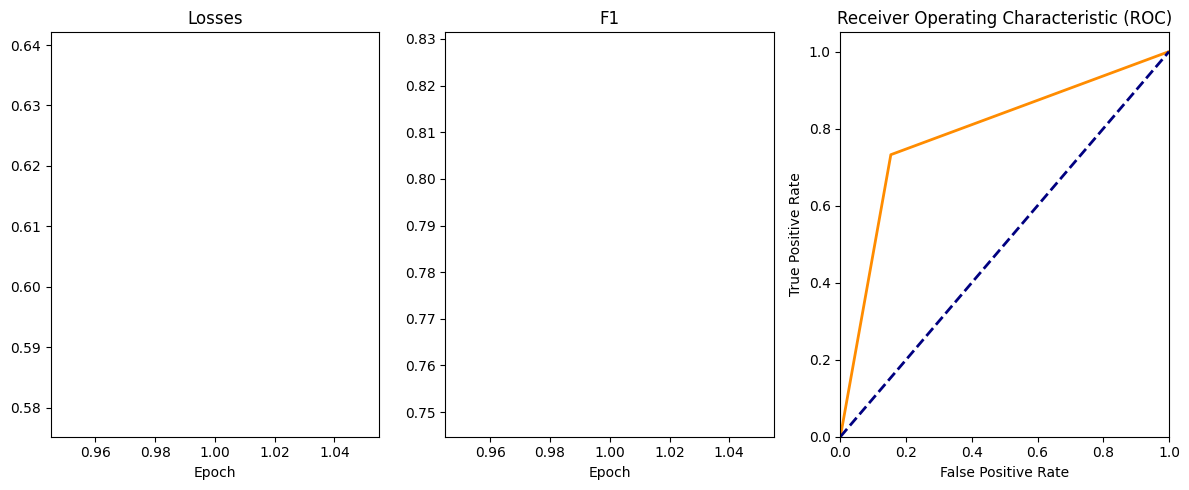

Training epoch 2:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.70      0.98      0.82      1231
         1.0       0.97      0.66      0.79      1498

    accuracy                           0.80      2729
   macro avg       0.84      0.82      0.80      2729
weighted avg       0.85      0.80      0.80      2729

Min Loss = 0.5733984713100835, Curr F1 = 0.7855153203342619, Max F1 = 0.7880747126436781, Curr AUC_ROC = 0.8180663847491213, Max AUC_ROC = 0.8180663847491213


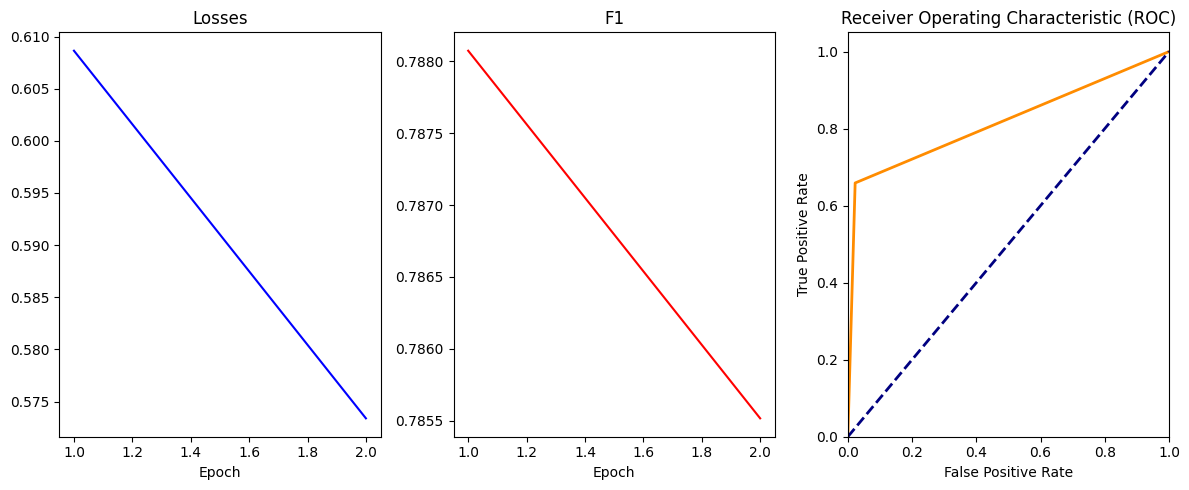

Training epoch 3:   0%|          | 0/10913 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
model_rnn = OtchislenieModel(hidden_dim=256, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

In [64]:
model_rnn = OtchislenieModel(hidden_dim=128, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

In [28]:
model_rnn = OtchislenieModel(hidden_dim=512, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

GRU Base Structure

Training epoch 1:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.72      0.94      0.81      1231
         1.0       0.94      0.69      0.80      1498

    accuracy                           0.81      2729
   macro avg       0.83      0.82      0.81      2729
weighted avg       0.84      0.81      0.81      2729

Min Loss = 0.5782437805408279, Curr F1 = 0.797390636991558, Max F1 = 0.797390636991558, Curr AUC_ROC = 0.8187697325109352, Max AUC_ROC = 0.8187697325109352


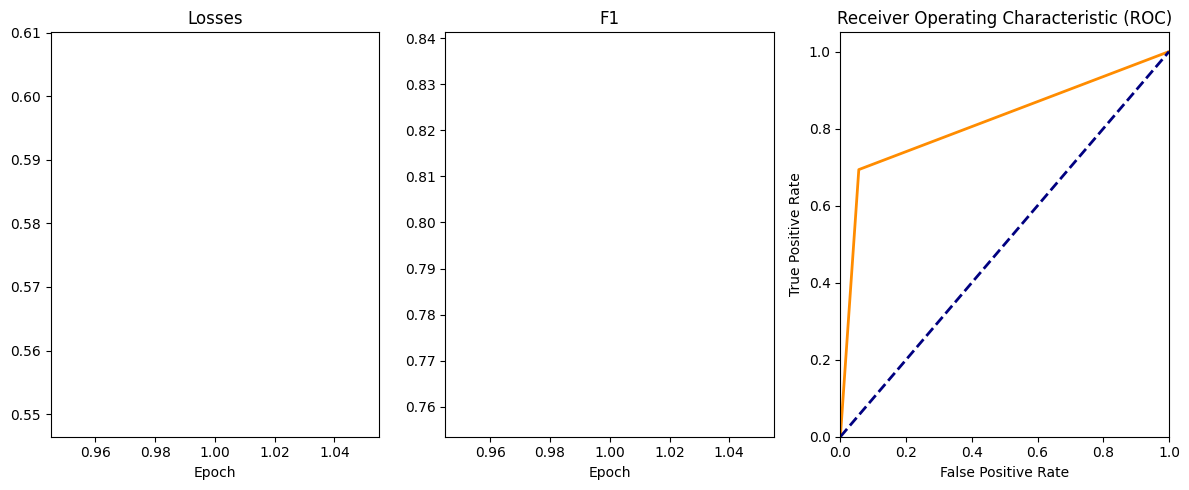

Training epoch 2:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.71      0.94      0.81      1231
         1.0       0.94      0.69      0.79      1498

    accuracy                           0.80      2729
   macro avg       0.82      0.82      0.80      2729
weighted avg       0.84      0.80      0.80      2729

Min Loss = 0.5627257888912226, Curr F1 = 0.7935409457900807, Max F1 = 0.797390636991558, Curr AUC_ROC = 0.8156209362279953, Max AUC_ROC = 0.8187697325109352


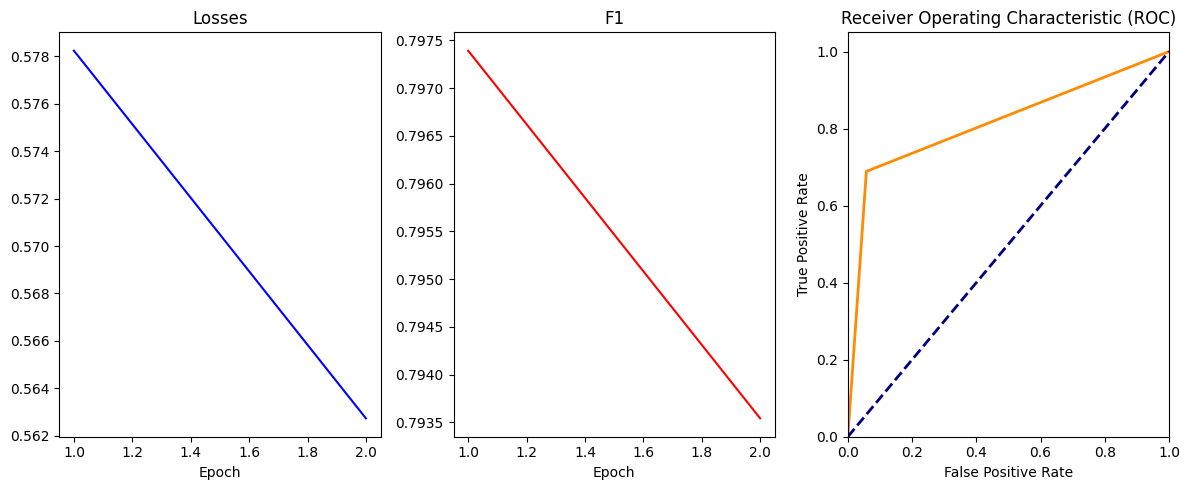

Training epoch 3:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      1231
         1.0       0.95      0.70      0.81      1498

    accuracy                           0.82      2729
   macro avg       0.84      0.83      0.82      2729
weighted avg       0.85      0.82      0.82      2729

Min Loss = 0.5605274812499904, Curr F1 = 0.8075442648190916, Max F1 = 0.8075442648190916, Curr AUC_ROC = 0.8294186453858327, Max AUC_ROC = 0.8294186453858327


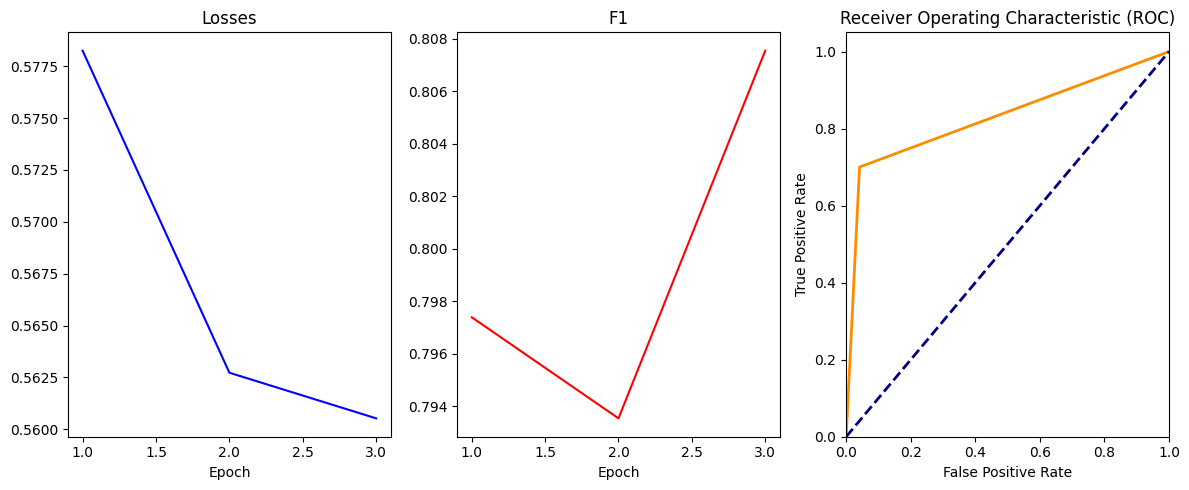

Training epoch 4:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.73      0.93      0.82      1231
         1.0       0.92      0.72      0.81      1498

    accuracy                           0.81      2729
   macro avg       0.83      0.82      0.81      2729
weighted avg       0.84      0.81      0.81      2729

Min Loss = 0.5587034159075664, Curr F1 = 0.8069251035001882, Max F1 = 0.8075442648190916, Curr AUC_ROC = 0.8224732895959845, Max AUC_ROC = 0.8294186453858327


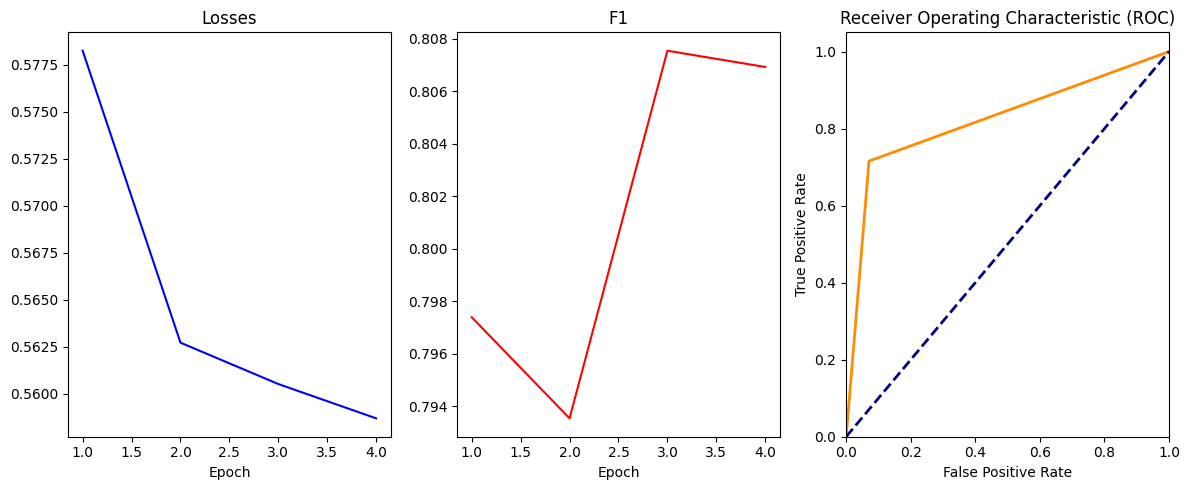

Training epoch 5:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.72      0.94      0.82      1231
         1.0       0.93      0.71      0.80      1498

    accuracy                           0.81      2729
   macro avg       0.83      0.82      0.81      2729
weighted avg       0.84      0.81      0.81      2729

Min Loss = 0.5587034159075664, Curr F1 = 0.8030360531309297, Max F1 = 0.8075442648190916, Curr AUC_ROC = 0.8210497831389592, Max AUC_ROC = 0.8294186453858327


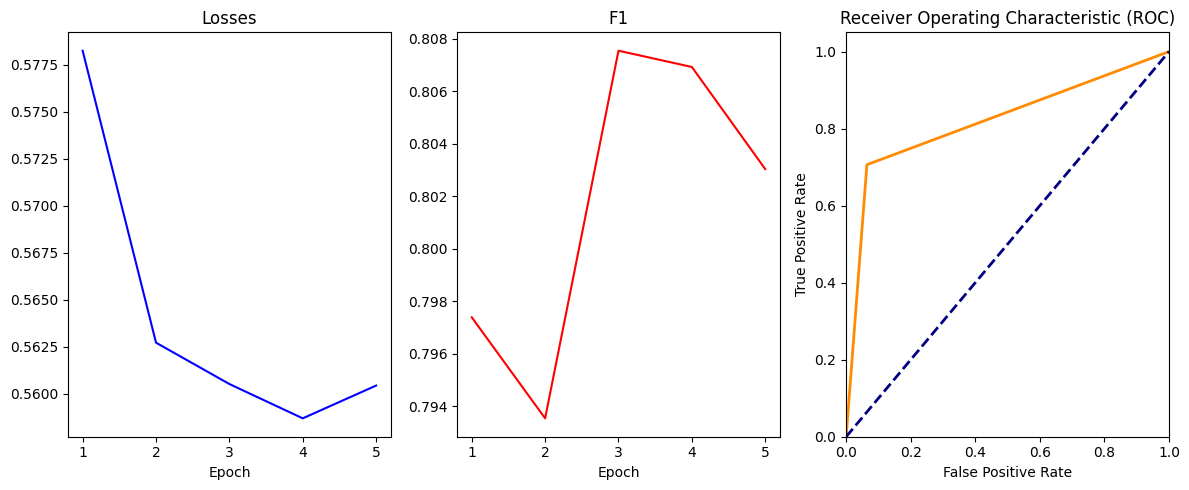

Training epoch 6:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.71      0.94      0.81      1231
         1.0       0.93      0.68      0.79      1498

    accuracy                           0.80      2729
   macro avg       0.82      0.81      0.80      2729
weighted avg       0.83      0.80      0.80      2729

Min Loss = 0.5565616632812151, Curr F1 = 0.7895142636854279, Max F1 = 0.8075442648190916, Curr AUC_ROC = 0.8125445354162983, Max AUC_ROC = 0.8294186453858327


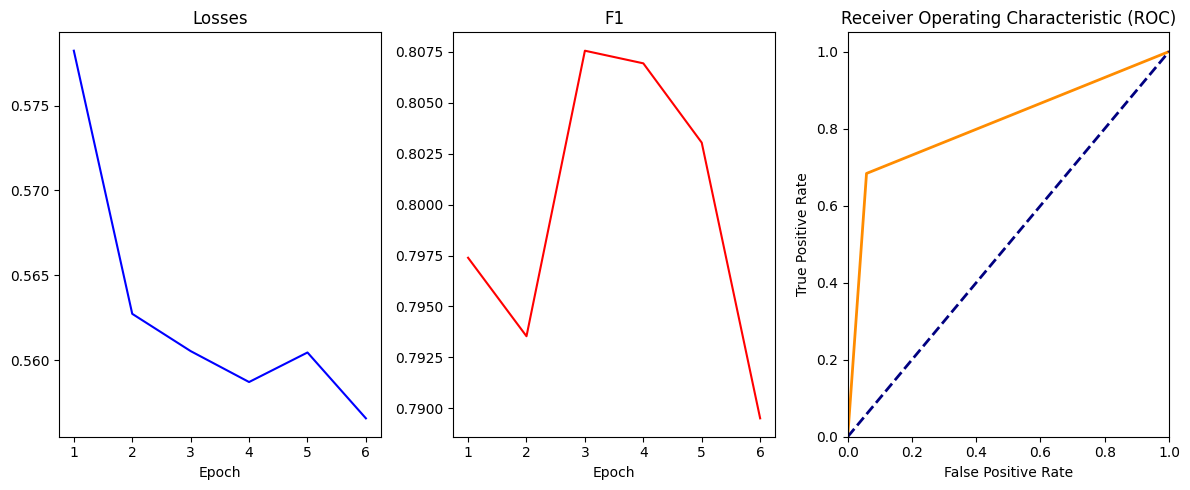

Training epoch 7:   0%|          | 0/10913 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
model_gru = OtchislenieModel_GRU(hidden_dim=256, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

In [ ]:
model_gru = OtchislenieModel_GRU(hidden_dim=128, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

In [ ]:
model_gru = OtchislenieModel_GRU(hidden_dim=512, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

LSTM Base Structure

Training epoch 1:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.81      1231
         1.0       0.94      0.66      0.78      1498

    accuracy                           0.79      2729
   macro avg       0.82      0.81      0.79      2729
weighted avg       0.83      0.79      0.79      2729

Min Loss = 0.5779150485293321, Curr F1 = 0.779037935080172, Max F1 = 0.779037935080172, Curr AUC_ROC = 0.8068543056054159, Max AUC_ROC = 0.8068543056054159


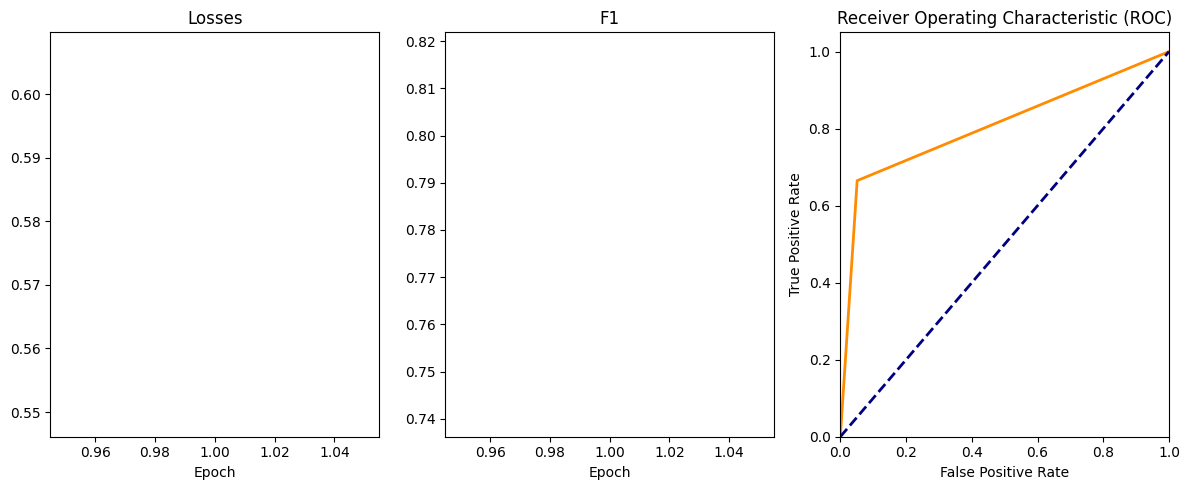

Training epoch 2:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.82      1231
         1.0       0.95      0.69      0.80      1498

    accuracy                           0.81      2729
   macro avg       0.83      0.82      0.81      2729
weighted avg       0.84      0.81      0.81      2729

Min Loss = 0.5603832653596073, Curr F1 = 0.7967479674796748, Max F1 = 0.7967479674796748, Curr AUC_ROC = 0.8207122087505789, Max AUC_ROC = 0.8207122087505789


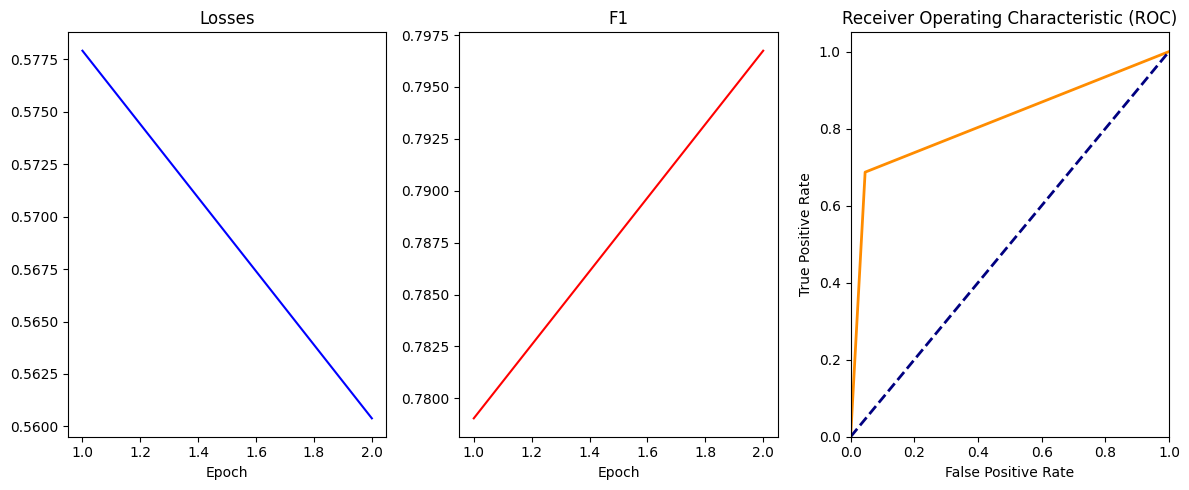

Training epoch 3:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.74      0.93      0.82      1231
         1.0       0.93      0.73      0.82      1498

    accuracy                           0.82      2729
   macro avg       0.83      0.83      0.82      2729
weighted avg       0.84      0.82      0.82      2729

Min Loss = 0.5546543042846335, Curr F1 = 0.817196261682243, Max F1 = 0.817196261682243, Curr AUC_ROC = 0.8307011569175906, Max AUC_ROC = 0.8307011569175906


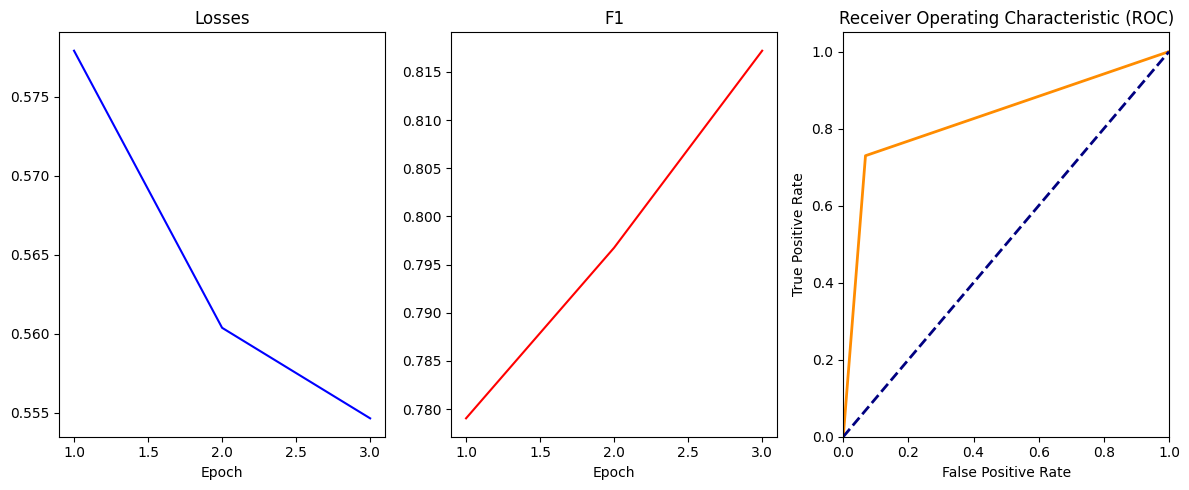

Training epoch 4:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.74      0.94      0.83      1231
         1.0       0.93      0.73      0.82      1498

    accuracy                           0.82      2729
   macro avg       0.84      0.83      0.82      2729
weighted avg       0.84      0.82      0.82      2729

Min Loss = 0.5512877305585392, Curr F1 = 0.817397825271841, Max F1 = 0.817397825271841, Curr AUC_ROC = 0.8317306910161287, Max AUC_ROC = 0.8317306910161287


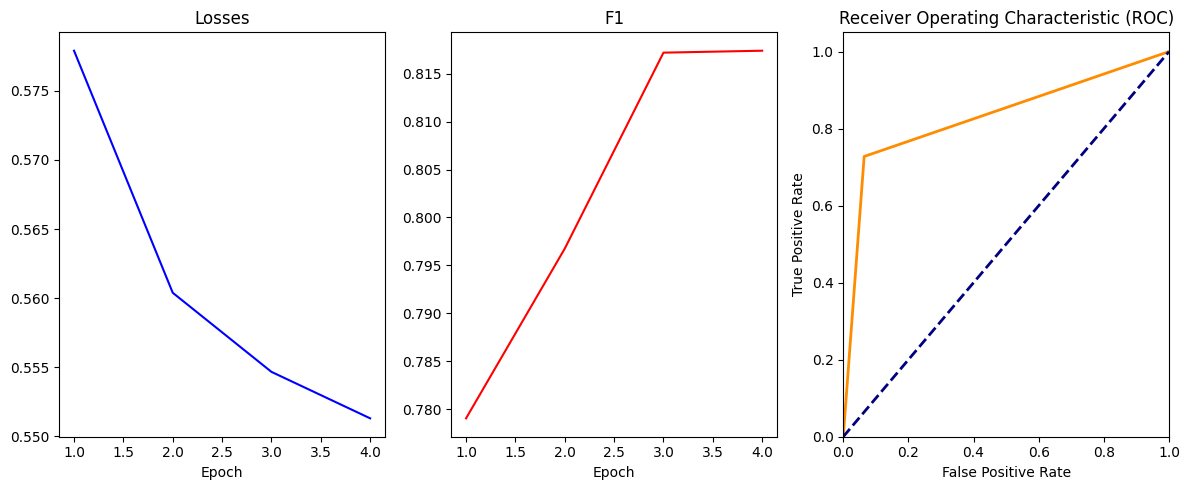

Training epoch 5:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.74      0.95      0.83      1231
         1.0       0.95      0.72      0.82      1498

    accuracy                           0.82      2729
   macro avg       0.84      0.83      0.82      2729
weighted avg       0.85      0.82      0.82      2729

Min Loss = 0.5489954767557721, Curr F1 = 0.8171471927162367, Max F1 = 0.817397825271841, Curr AUC_ROC = 0.8347027013543105, Max AUC_ROC = 0.8347027013543105


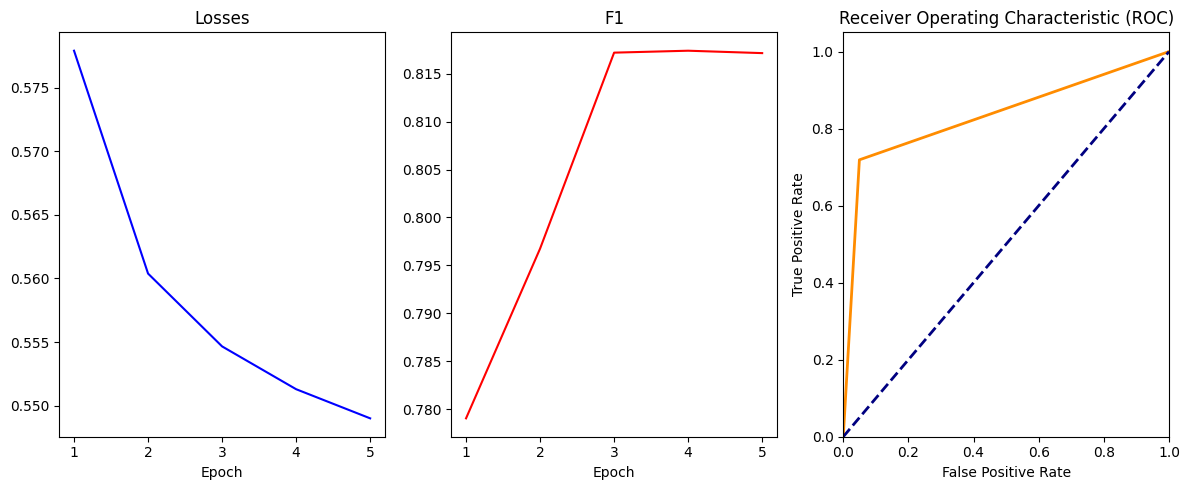

Training epoch 6:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83      1231
         1.0       0.93      0.74      0.83      1498

    accuracy                           0.83      2729
   macro avg       0.84      0.84      0.83      2729
weighted avg       0.85      0.83      0.83      2729

Min Loss = 0.5465717491844251, Curr F1 = 0.8266369047619048, Max F1 = 0.8266369047619048, Curr AUC_ROC = 0.8387400368105212, Max AUC_ROC = 0.8387400368105212


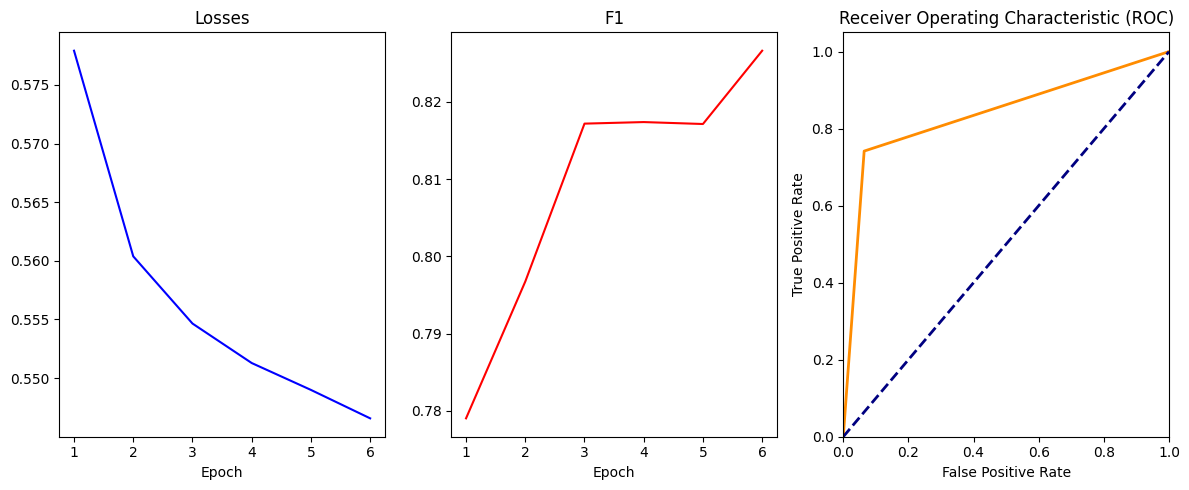

Training epoch 7:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.74      0.95      0.83      1231
         1.0       0.95      0.73      0.82      1498

    accuracy                           0.83      2729
   macro avg       0.84      0.84      0.83      2729
weighted avg       0.85      0.83      0.83      2729

Min Loss = 0.5446627669075303, Curr F1 = 0.8226843100189036, Max F1 = 0.8266369047619048, Curr AUC_ROC = 0.8391866111218966, Max AUC_ROC = 0.8391866111218966


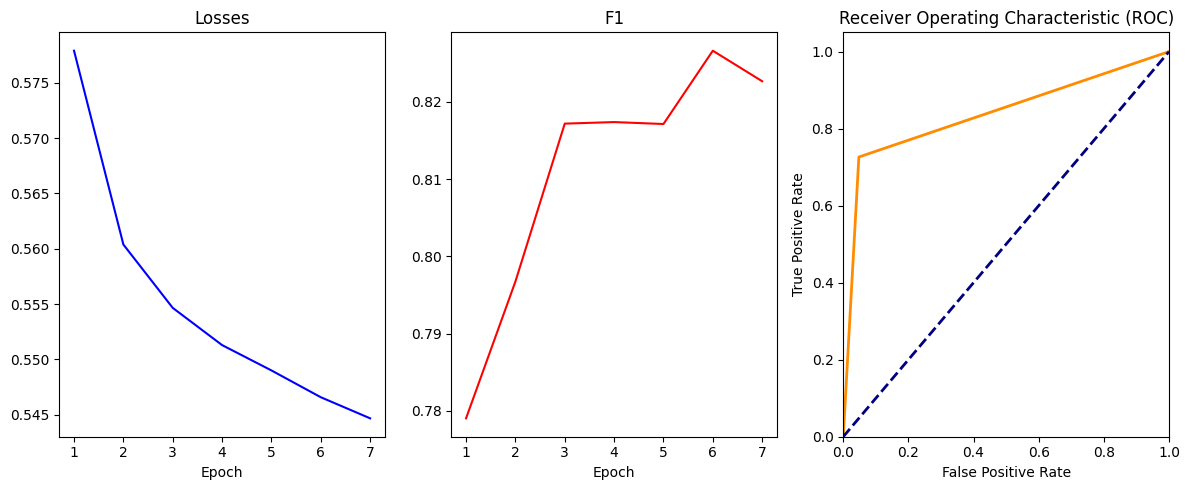

Training epoch 8:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.84      1231
         1.0       0.94      0.74      0.83      1498

    accuracy                           0.83      2729
   macro avg       0.85      0.84      0.83      2729
weighted avg       0.86      0.83      0.83      2729

Min Loss = 0.5443005509012988, Curr F1 = 0.8307233407904548, Max F1 = 0.8307233407904548, Curr AUC_ROC = 0.8433969365056468, Max AUC_ROC = 0.8433969365056468


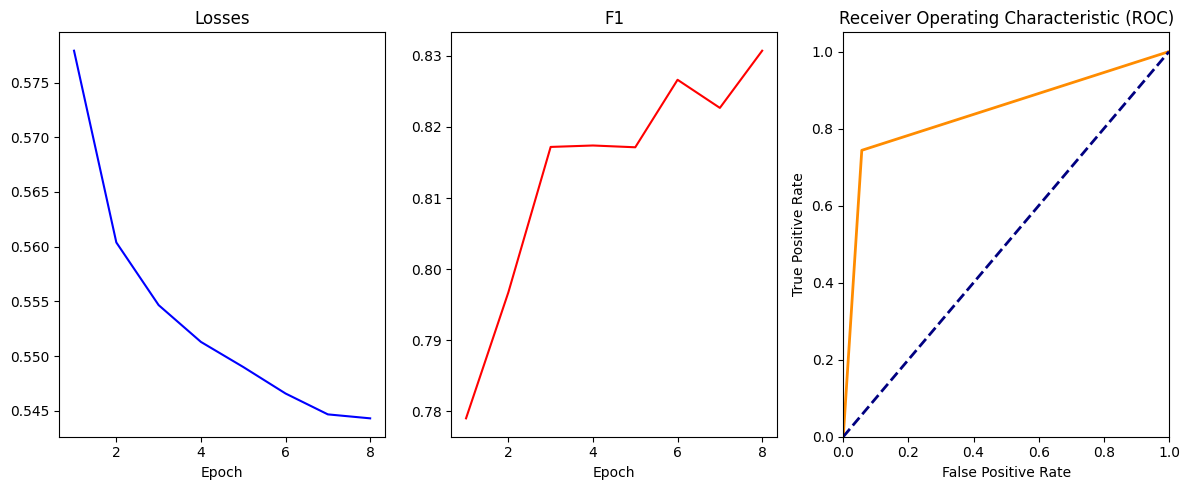

Training epoch 9:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83      1231
         1.0       0.93      0.74      0.83      1498

    accuracy                           0.83      2729
   macro avg       0.84      0.84      0.83      2729
weighted avg       0.85      0.83      0.83      2729

Min Loss = 0.542601497152773, Curr F1 = 0.8269445478228508, Max F1 = 0.8307233407904548, Curr AUC_ROC = 0.8391462106529258, Max AUC_ROC = 0.8433969365056468


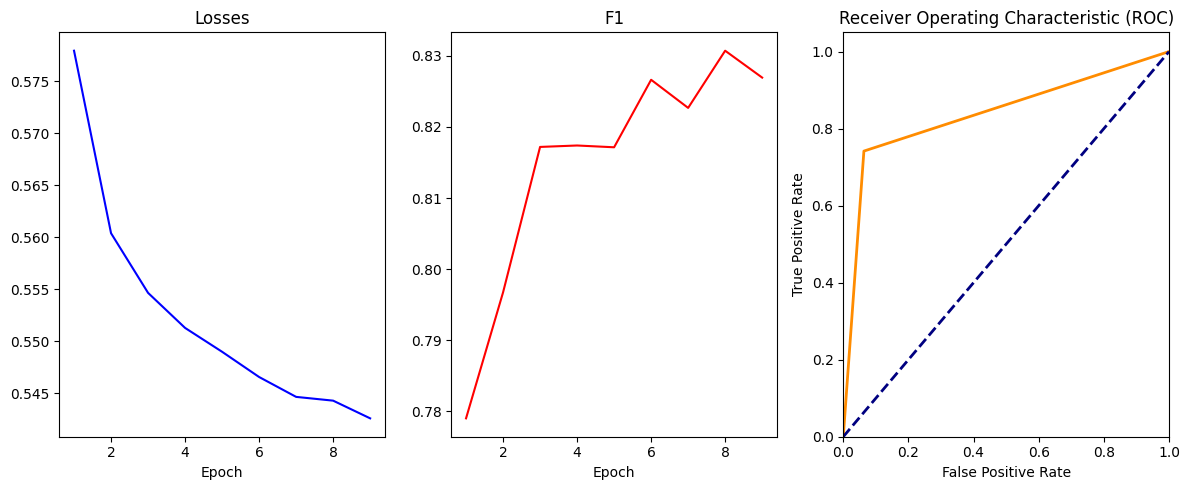

Training epoch 10:   0%|          | 0/10913 [00:00<?, ?it/s]

Testing:   0%|          | 0/2729 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.73      0.93      0.82      1231
         1.0       0.93      0.72      0.81      1498

    accuracy                           0.81      2729
   macro avg       0.83      0.83      0.81      2729
weighted avg       0.84      0.81      0.81      2729

Min Loss = 0.5422376065525991, Curr F1 = 0.8102217211574596, Max F1 = 0.8307233407904548, Curr AUC_ROC = 0.8252883075077628, Max AUC_ROC = 0.8433969365056468


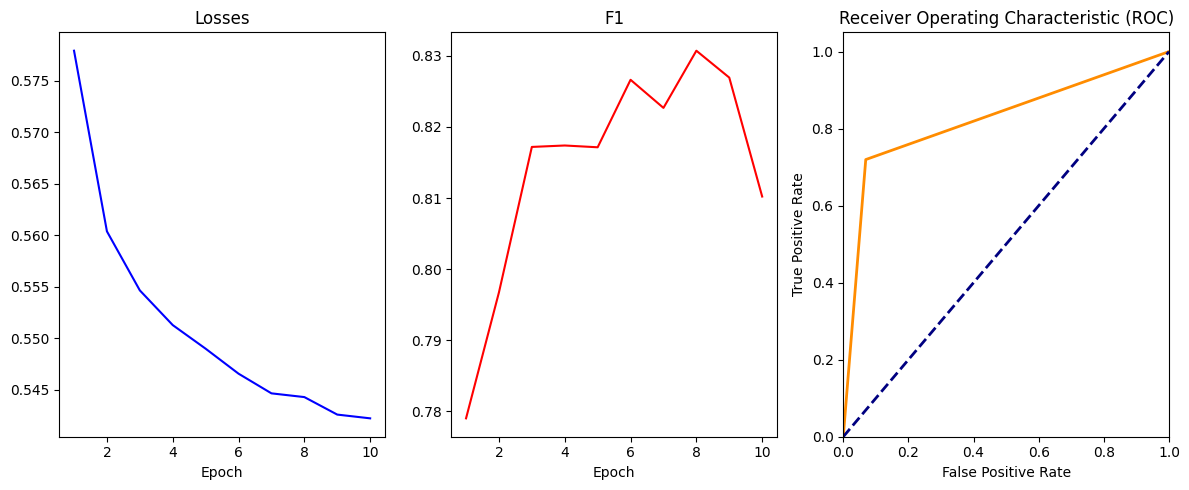

In [22]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=256, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

In [ ]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=128, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

In [ ]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=512, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

Vanilla RNN Custom Structure

In [ ]:
model_rnn_custom = OtchislenieModel_CustomStructure(input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn_custom.parameters())

model_rnn_custom = train_model(model_rnn_custom, optimizer, criterion, num_epoch=10)

GRU Custom Structure

In [ ]:
model_gru_custom = OtchislenieModel_GRU_CustomStructure(input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru_custom.parameters())

model_gru_custom = train_model(model_gru_custom, optimizer, criterion, num_epoch=10)

LSTM Custom Structure

In [ ]:
model_lstm_custom = OtchislenieModel_LSTM_CustomStructure(input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm_custom.parameters())

model_lstm_custom = train_model(model_lstm_custom, optimizer, criterion, num_epoch=10)